
<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP6</h2></center>

# Importation des librairies

In [13]:
!pip install bayesian-optimization

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from bayes_opt import BayesianOptimization


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.random.set_seed(42)
tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)

# Configaration GPU

In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [3]:
df = pd.read_csv("data.csv", sep=";")

df.head(10)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


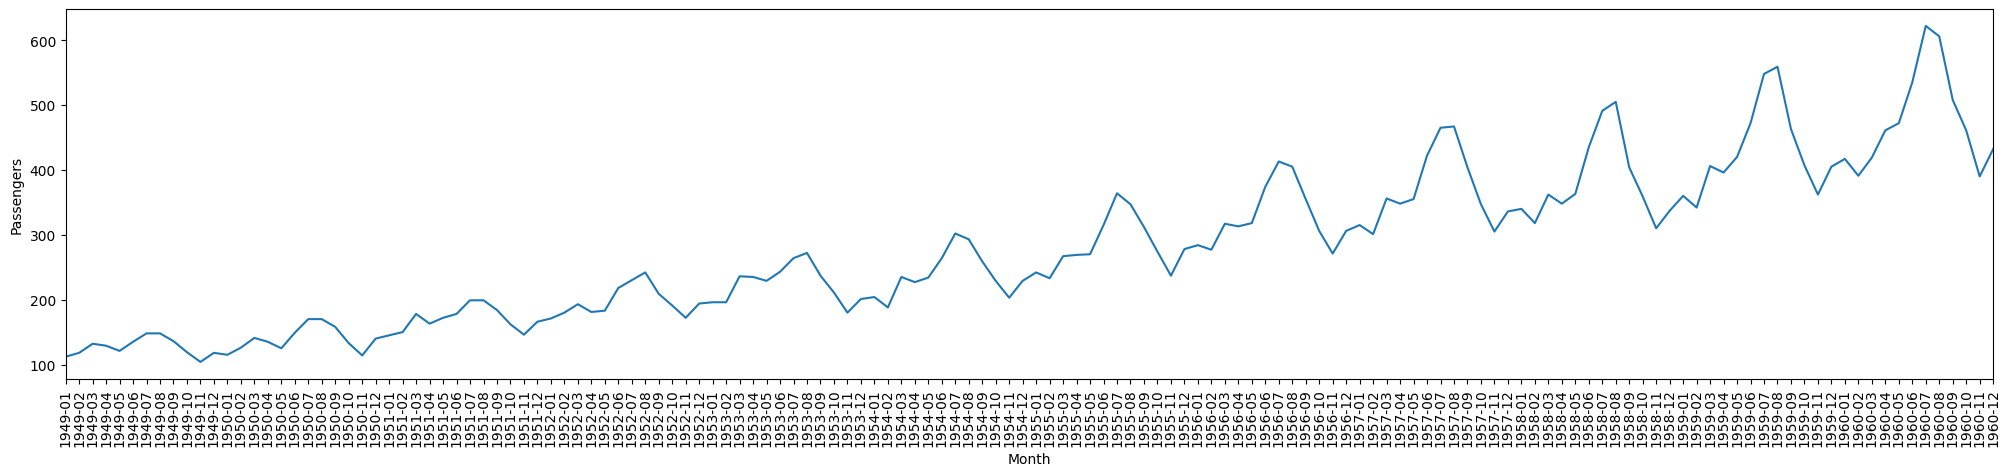

In [4]:
plt.plot(df["Month"], df["Passengers"])
plt.xlabel("Month")

N = len(df)
plt.xticks(rotation=90)
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.ylabel("Passengers")
plt.show()

# Prétraitement du dataset

## Normalisation des données

In [6]:
dataset = df["Passengers"].to_numpy()
dataset = dataset.astype('float32')
dataset= dataset.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Application du sliding window & Division en set d'entrainement de validation et de teste

In [7]:
def slide_window(dataset, step=1):
 data_X, data_Y = [], []
 for i in range(len(dataset)-step-1):
  a = dataset[i:(i+step), 0]
  data_X.append(a)
  data_Y.append(dataset[i + step, 0])
 return np.array(data_X), np.array(data_Y)

In [10]:
step = 3
X_train, X_test, Y_train, Y_test = train_test_split(slide_window(dataset, step)[0], slide_window(dataset, step)[1], test_size=0.33, random_state=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=True)

In [11]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((93, 3), (93,), (24, 3), (24,), (23, 3), (23,))

## Normalisation des données (suite)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [20]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((93, 1, 3), (93,), (24, 1, 3), (24,), (23, 1, 3), (23,))

# Création de l'architecture de notre modèle

In [21]:
def GRU_training(nbn, bs, dp):
  with tf.device(device_name):
    model = Sequential()

    model.add(GRU(int(nbn), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dp))

    model.add(GRU(int(nbn)*2, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dp))

    model.add(Dense(1))
    model.add(Activation('linear'))

    checkpointer = ModelCheckpoint(filepath='airline-passengers-LSTM.h5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

    history = model.fit(X_train, Y_train,
                          batch_size=int(bs), epochs=500,
                          verbose=0,
                          callbacks = [checkpointer, early],
                          validation_data=(X_val, Y_val))

    return -history.history['val_mean_squared_error'][-1]

# Affinage des hyperparamètres

## Utilisation de l'algorithme d'optimisatuon baysien

In [22]:
pbounds = {
    'nbn': (32, 256),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
    }


optimizer = BayesianOptimization(
    f=GRU_training,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    nbn    |
-------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 1         | -0.02446  | 232.2     | 0.3881    | 32.03     |
| 2         | -0.02788  | 177.1     | 0.1587    | 52.68     |
| 3         | -0.0415   | 121.4     | 0.2382    | 120.9     |
| 4         | -0.04438  | 290.6     | 0.2677    | 185.5     |
| 5         | -0.0241   | 130.1     | 0.4512    | 38.13     |
| 6         | -0.04375  | 353.8     | 0.2669    | 157.1     |
| 7         | -0.04259  | 99.39     | 0.1792    | 211.4     |
| 8         | -0.04872  | 496.8     | 0.2254    | 187.1     |
| 9         | -0.0289   | 452.7     | 0.4578    | 51.05     |
| 10        | -0.005608 | 50.75     | 0.1679    | 228.7     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 11        | -0.007718 | 50.3      | 0.2807    | 229.0     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 12        | -0.003651 | 52.94     | 0.4806    | 224.6     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 13        | -0.008828 | 58.17     | 0.3418    | 228.2     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 14        | -0.005251 | 45.14     | 0.1622    | 216.1     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 15        | -0.009233 | 52.44     | 0.449     | 209.0     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 16        | -0.004321 | 39.0      | 0.4981    | 207.5     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 17        | -0.003303 | 33.16     | 0.1283    | 216.2     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 18        | -0.007982 | 45.34     | 0.1568    | 196.1     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 19        | -0.003409 | 32.0      | 0.1       | 196.9     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 20        | -0.003355 | 35.04     | 0.1188    | 184.0     |
Bayes optimization takes 178.96 seconds to tune
{'target': -0.0033030861523002386, 'params': {'bs': 33.157215937017796, 'dp': 0.12827160159044323, 'nbn': 216.19717726776983}}


# Entrainement du modèle avec les meillieurs hyperparamètres

In [28]:
nbn = optimizer.max["params"]["nbn"]
dp = optimizer.max["params"]["dp"]
bs = optimizer.max["params"]["bs"]

with tf.device(device_name):
  model = Sequential()

  model.add(GRU(int(nbn), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(dp))

  model.add(GRU(int(nbn)*2, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(dp))

  model.add(Dense(1))
  model.add(Activation('linear'))

  checkpointer = ModelCheckpoint(filepath='airline-passengers-GRU.keras', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
  early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

  model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

  history = model.fit(X_train, Y_train,
                        batch_size=int(bs), epochs=500,
                        verbose=2,
                        callbacks = [checkpointer, early],
                        validation_data=(X_val, Y_val))

Epoch 1/500
3/3 - 5s - loss: 0.1545 - mean_squared_error: 0.1545 - mean_absolute_percentage_error: 7640.4048 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_percentage_error: 40.7034 - 5s/epoch - 2s/step
Epoch 2/500
3/3 - 0s - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_percentage_error: 993444.6250 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_percentage_error: 78.8615 - 291ms/epoch - 97ms/step
Epoch 3/500
3/3 - 0s - loss: 0.0232 - mean_squared_error: 0.0232 - mean_absolute_percentage_error: 2601348.7500 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_mean_absolute_percentage_error: 131.9693 - 125ms/epoch - 42ms/step
Epoch 4/500
3/3 - 0s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_percentage_error: 2721962.5000 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_percentage_error: 108.8427 - 55ms/epoch - 18ms/step
Epoch 5/500
3/3 - 0s - loss: 0.0199 - mean_squared_error: 0.0199

# Visualisation des résultats

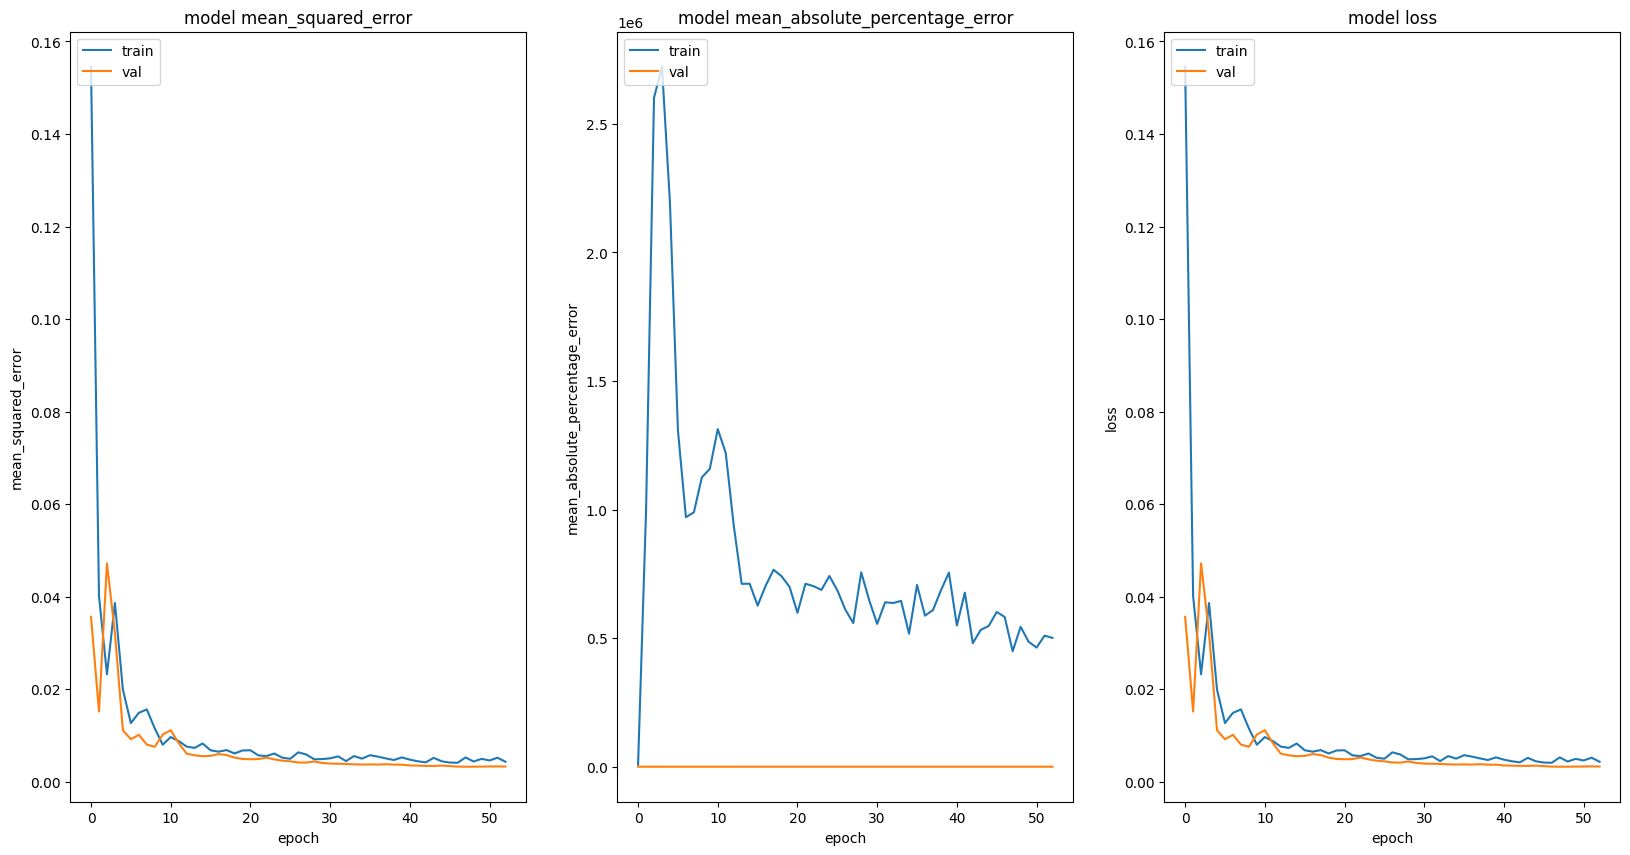

In [29]:
fig, axes = plt.subplots(1, 3,figsize=(20, 10))

axes[0].plot(history.history['mean_squared_error'])
axes[0].plot(history.history['val_mean_squared_error'])
axes[0].set_title('model mean_squared_error')
axes[0].set_ylabel('mean_squared_error')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')

axes[1].plot(history.history['mean_absolute_percentage_error'])
axes[1].plot(history.history['val_mean_absolute_percentage_error'])
axes[1].set_title('model mean_absolute_percentage_error')
axes[1].set_ylabel('mean_absolute_percentage_error')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

axes[2].plot(history.history['loss'])
axes[2].plot(history.history['val_loss'])
axes[2].set_title('model loss')
axes[2].set_ylabel('loss')
axes[2].set_xlabel('epoch')
axes[2].legend(['train', 'val'], loc='upper left')

# Test du modèle

In [30]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


## Visualisation des résultats du test

In [37]:
testScore = np.sqrt(mean_squared_error(Y_test, y_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.05 RMSE


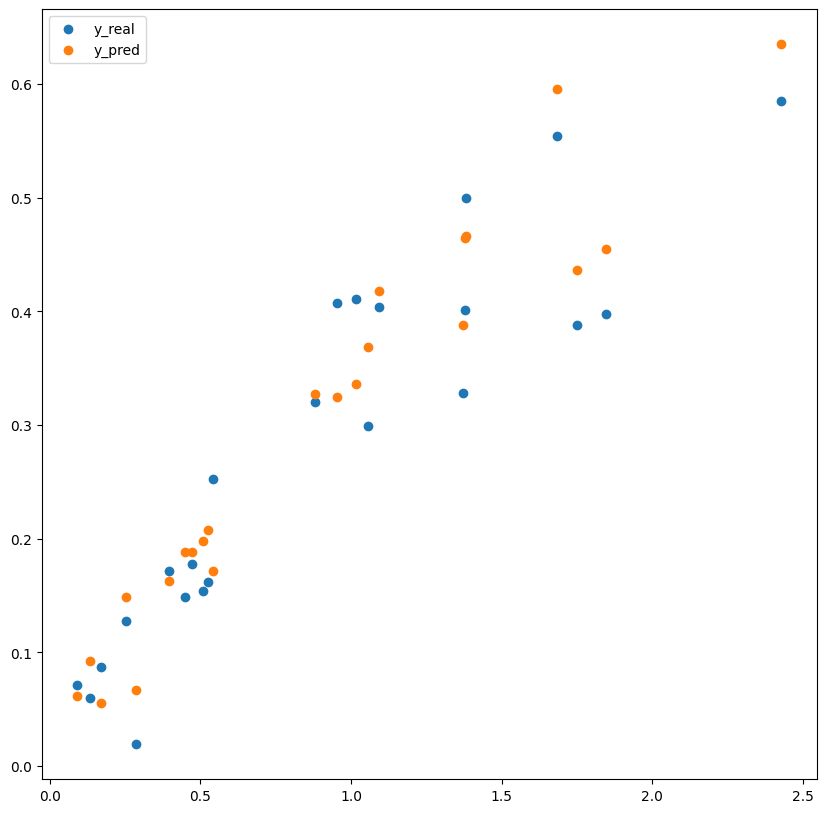

In [49]:
simplified_X = [item for sublist in np.sum(X_test, axis=2) for item in sublist]

fig = plt.figure(figsize=(10, 10))
plt.scatter(simplified_X, Y_test, label='y_real')
plt.scatter(simplified_X, y_pred, label='y_pred')
plt.legend()
plt.show()